# Introduction

Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The data features that you use to train your machine learning models have a huge influence on the performance you can achieve. Irrelevant or partially relevant features can negatively impact model performance.
#### what are Benefits of performing feature selection before modeling your data?
· Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.

· Improves Accuracy: Less misleading data means modeling accuracy improves.

· Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.

In this notebook I will explain feature selection by Greedy approach using library Sequential Feature Selector.
Here i am using only loading feature for this task for sake of simplicity.

# Acknowledgement



1. Feature selection by : [https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e](http://)

2. Sequential Feature Selector : [http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/](http://)

# Content

> ### 1. Import Libraries
> ### 2. Read the data
> ### 3. Train_test_split
> ### 4. Preprocessing
> ### 5. Load the model and apply feature selection algorithm
> ### 6. Visualize the count of feature vs Loss for each target variable

### 1. Import Libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn. preprocessing import MinMaxScaler
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import plotly.graph_objects as go
import xgboost as xgb
import plotly.graph_objects as go
from sklearn.tree import DecisionTreeRegressor


### 2.Read the data

In [ ]:
train_df = pd.read_csv('../input/trends-assessment-prediction/train_scores.csv', dtype={'Id':str})\
            .dropna().reset_index(drop=True) # Load train dataFrame
loading_df = pd.read_csv('../input/trends-assessment-prediction/loading.csv', dtype={'Id':str})

In [ ]:
# Lets merge train df with loading_df
train_df = train_df.merge(loading_df, on='Id', how='left')
train_df.head() 

In [ ]:
train_df.shape

In [ ]:
X_train = train_df.iloc[:,6:]  #Train feature
target = train_df.iloc[:,1:6]   #Target feature
X_train.head()

### 3. Split the data into train and test set

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(X_train,target,test_size=0.33,shuffle=True) #Lets split the data

### 4. Preprocessing 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(x_train)  ##Fit on train set
x_train = scaler.transform(x_train)  ##transform train set
x_val = scaler.transform(x_val)   ##transform validaion set

In [ ]:
x_train = pd.DataFrame(x_train,columns=X_train.columns)  ##Convert numpy into dataframe
x_val = pd.DataFrame(x_val,columns=X_train.columns)

In [ ]:
loss_wt = [.3, .175, .175, .175, .175]  ##weight for each target variable in calculatting loss (Given)

In [ ]:
def k_loss(weight,y_pred,y_true):   ##Lets define the loss function
    s = np.sum(np.abs(y_pred-y_true))/np.sum(y_true)
    return weight*s

### 5. Lets load the model

In [ ]:
#model =  LGBMRegressor(random_state=17)  #Lets define model for feature selection
#model = xgb.XGBRegressor(tree_method= 'gpu_hist') ##
model = DecisionTreeRegressor() #You can use your own model for feature selection

In [ ]:
col = target.columns

### 5.1 Apply Feature selection using sequential feature selector

#### Overview:
Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. The motivation behind feature selection algorithms is to automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the generalization error of the model by removing irrelevant features or noise.

#### Pseudo Code:

##### Input: Y={y1,y2,...,yd}

The SFS algorithm takes the whole d-dimensional feature set as input.
##### Output: Xk={xj|j=1,2,...,k;xj∈Y}, where k=(0,1,2,...,d)

SFS returns a subset of features; the number of selected features k, where k<d, has to be specified a priori.
##### Initialization: X0=∅, k=0

We initialize the algorithm with an empty set ∅ ("null set") so that k=0 (where k is the size of the subset).
##### Step 1 (Inclusion):

x+= arg max J(xk+x), where x∈Y−Xk
Xk+1=Xk+x+
k=k+1
Go to Step 1

in this step, we add an additional feature, x+, to our feature subset Xk.
x+ is the feature that maximizes our criterion function, that is, the feature that is associated with the best classifier performance if it is added to Xk.
We repeat this procedure until the termination criterion is satisfied.
##### Termination: k=p

We add features from the feature subset Xk until the feature subset of size k contains the number of desired features p that we specified a priori.



Source : [http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/](http://)

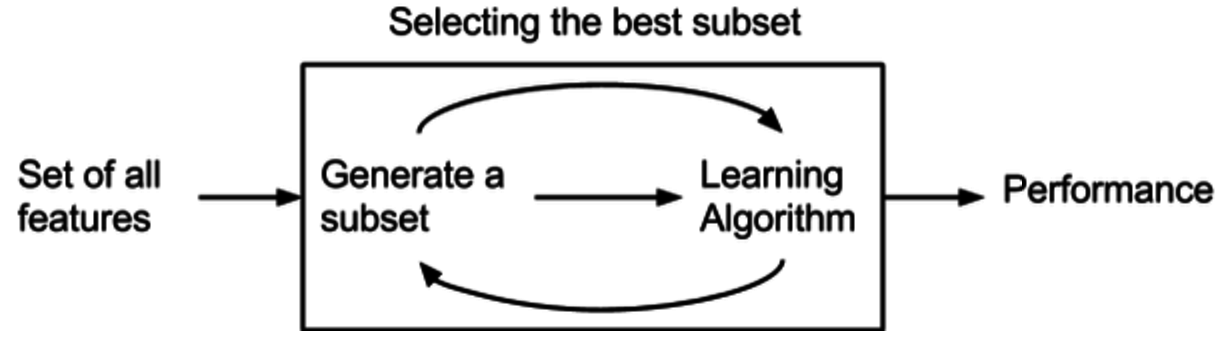

In [ ]:
loss_dict ={} #To keep the history of loss
best_feat_col ={} #Dictionary to store best feature for each target variable

for i in range(5): #Iterate for every target feature
    print("Selecting best feature subset for " +str(col[i])+".....")
    min_loss=1000
    store =[]
    best_feature=[]
    #best_feature
    for x in range(1,27): ##Iterate for x best subset among 26 feature
        sfs = SFS(model,k_features=x,forward=True,floating=False,scoring = 'neg_mean_squared_error',cv = 0) #For forward selection set forward to True
        sfs.fit(x_train, y_train.iloc[:,i])
        col_n = list((sfs.k_feature_names_))
        model.fit(x_train[col_n],y_train.iloc[:,i])
        loss = k_loss(loss_wt[i],y_val.iloc[:,i],model.predict(x_val[col_n]))
        if(loss<min_loss):
            min_loss=loss
            best_feature = col_n
        store.append(loss)
    best_feat_col[col[i]]= list(best_feature)
    loss_dict[col[i]]=store
            
    

## Lets Plot Count of feature vs different Target variables

### 1. Age

In [ ]:
fig = go.Figure(data=go.Scatter(x=list(range(1,27)), y=loss_dict['age']))
fig.update_layout(title='Count of best features vs Loss for "AGE"',
                   xaxis_title='Count of features',
                   yaxis_title='Loss')
fig.show()

### 2. Domain1_var1

In [ ]:
fig = go.Figure(data=go.Scatter(x=list(range(1,27)), y=loss_dict['domain1_var1']))
fig.update_layout(title='Count of best features vs Loss for "domain1_var1"',
                   xaxis_title='Count of features',
                   yaxis_title='Loss')
fig.show()

### 3. Domain1_var2

In [ ]:
fig = go.Figure(data=go.Scatter(x=list(range(1,27)), y=loss_dict['domain1_var2']))
fig.update_layout(title='Count of best features vs Loss for "domain1_var2"',
                   xaxis_title='Count of features',
                   yaxis_title='Loss')
fig.show()

### 4. Domain2_var1

In [ ]:
fig = go.Figure(data=go.Scatter(x=list(range(1,27)), y=loss_dict['domain2_var1']))
fig.update_layout(title='Count of best features vs Loss for "domain2_var1"',
                   xaxis_title='Count of features',
                   yaxis_title='Loss')
fig.show()

### 5. Domain2_var2

In [ ]:
fig = go.Figure(data=go.Scatter(x=list(range(1,27)), y=loss_dict['domain2_var2']))
fig.update_layout(title='Count of best features vs Loss for "domain2_var2"',
                   xaxis_title='Count of features',
                   yaxis_title='Loss')
fig.show()

### Lets see the best features (Extracted by our algorithm)

#### 1.For Age

In [ ]:
best_feat_col['age']

#### 2.For domain1_var1

In [ ]:
best_feat_col['domain1_var1']

#### 3.For domain1_var2

In [ ]:
best_feat_col['domain1_var2']  ##Interesting result

#### 4.For domain2_var1

In [ ]:
best_feat_col['domain2_var1']

#### 1.For domain2_var2

In [ ]:
best_feat_col['domain2_var2']

******************************************************************************

> #  If you like this notebook please support me with a upvote :)